In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np 
from sqlalchemy import create_engine
import mysql.connector

In [2]:
try:
    connection = mysql.connector.connect(host='localhost',
                                             database='project2',
                                             user='root',
                                             password='MosiSQL$$')
    #Customers
    cursor = connection.cursor()
    cursor.execute('select * from product')
    record = cursor.fetchall()
    dfCustomer=pd.DataFrame(record ,columns=[i[0] for i in cursor.description])
    #Order 
    cursor = connection.cursor()
    cursor.execute('select * from `order`')
    record = cursor.fetchall()
    dfOrder  = pd.DataFrame(record , columns=[i[0] for i  in cursor.description])

    # #order_detail 
    cursor = connection.cursor()
    cursor.execute('select * from order_detail')
    record = cursor.fetchall()
    dfOrderDetails = pd.DataFrame(record , columns=[i[0] for i in cursor.description])

    
except mysql.connector.Error as error:
    print("Failed to get record from database: {}".format(error))

finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed")


MySQL connection is closed


In [3]:
df = pd.merge(dfOrderDetails , dfOrder , on = 'Order ID').drop(columns=['Row ID','Order ID','Order Date','Customer ID'])

In [4]:
from sklearn.preprocessing import LabelEncoder , OrdinalEncoder
labelMarket  = LabelEncoder()
labelPriority = LabelEncoder()
labelProduct = LabelEncoder()
df['Market'] =  labelMarket.fit_transform(df['Market'])
df['Order Priority'] = labelPriority.fit_transform(df['Order Priority'])
df['Product ID'] = labelPriority.fit_transform(df['Product ID'])

In [105]:
df.Profit.max()

8399.98

<Axes: xlabel='Profit', ylabel='Count'>

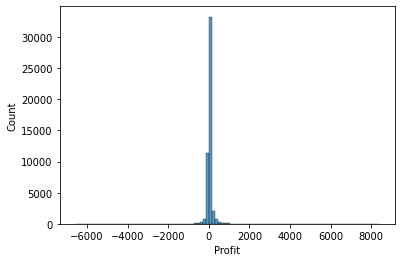

In [140]:
import seaborn as sns
sns.histplot(df['Profit'], bins=100)
# df['Profit']

In [5]:
df.corr()

,Product ID,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Market
Product ID,1.000000,0.022306,-0.018592,-0.045526,0.043911,0.020043,-0.001912,-0.042025
Sales,0.022306,1.000000,0.312206,-0.085969,0.486865,0.768075,-0.001234,-0.051769
Quantity,-0.018592,0.312206,1.000000,-0.017037,0.104731,0.272610,0.003148,0.075804
Discount,-0.045526,-0.085969,-0.017037,1.000000,-0.316201,-0.078325,0.005953,-0.014860
Profit,0.043911,0.486865,0.104731,-0.316201,1.000000,0.351848,0.000529,-0.019393
Shipping Cost,0.020043,0.768075,0.272610,-0.078325,0.351848,1.000000,-0.187438,-0.054279
Order Priority,-0.001912,-0.001234,0.003148,0.005953,0.000529,-0.187438,1.000000,-0.000643
Market,-0.042025,-0.051769,0.075804,-0.014860,-0.019393,-0.054279,-0.000643,1.000000


In [6]:
#Feature selection using mutual information and chi2   
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile ,mutual_info_classif,f_regression
data= df.drop(columns='Profit')
# feature scaling
scaler = MinMaxScaler()
standard = StandardScaler()
scaled = standard.fit_transform(data)
# scaled = data
# feature selection
# selector = SelectKBest(chi2, k=20)
selector = SelectPercentile(f_regression, percentile=90)

selected = selector.fit_transform(scaled,df['Profit'])

print('Number of features before selection:', data.shape[1])
print('Number of features after selection:', selected.shape[1])
data = pd.DataFrame(selected)


Number of features before selection: 7
Number of features after selection: 6


In [78]:
poly_transformer = PolynomialFeatures(degree=2, include_bias=True)
x_train, x_test, y_train, y_test = train_test_split(data, df['Profit'], train_size=.90, random_state=42)
x_val , x_test , y_val  , y_test = train_test_split(x_test , y_test , train_size=0.50 , random_state=42)   

x_train_trans = poly_transformer.fit_transform(x_train)
x_test_trans = poly_transformer.transform(x_test)
x_val_trans =  poly_transformer.transform(x_val)
modelReg = LinearRegression()
modelReg.fit(x_train_trans, y_train)
y_pred = modelReg.predict(x_val_trans)
print('r2_score : ',r2_score(y_val, y_pred))

r2_score :  0.6867074606200658


In [80]:
from sklearn.ensemble import RandomForestRegressor
# modelForest = RandomForestRegressor(n_estimators = 150 ,bootstrap= True, oob_score=True , max_samples=100,criterion='squared_error')
modelForest = RandomForestRegressor(max_depth=20, max_features='auto', min_samples_leaf=4,
                      min_samples_split=5)
# df.columns =df.columns.astype(str)
# train3 = finalDf
# train = train3[:7000]
# val = train3[7000:]
modelForest.fit(x_train ,y_train)
modelForest.get_params()
# model.score(val.drop(['gender'],axis=1),val['gender'])
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


pred = modelForest.predict(x_val)
print('r2_score : ',r2_score(y_val, pred))


C:\Users\mosta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


r2_score :  0.7185017071893038


In [ ]:
from flaml import AutoML
automl = AutoML()
automl.fit(x_train, y_train, task='regression')

In [16]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import keras 
from keras.optimizers import RMSprop , SGD , Adam
from keras.callbacks import EarlyStopping 
from sklearn import preprocessing 
from sklearn.preprocessing import scale


In [81]:
modelDeep = Sequential() 
modelDeep.add(Dense(128, kernel_initializer = 'normal', activation = 'relu',input_shape = (6,))) 
modelDeep.add(Dense(128, activation = 'relu'))
modelDeep.add(Dense(128, activation = 'relu'))
modelDeep.add(Dense(128, activation = 'relu'))
modelDeep.add(Dense(128, activation = 'relu'))
modelDeep.add(Dense(128, activation = 'relu'))
modelDeep.add(Dense(128, activation = 'relu'))
# modelDeep.add(Dense(64, activation = 'relu'))
# modelDeep.add(Dense(64, activation = 'relu'))



modelDeep.add(Dense(1))

In [82]:
modelDeep.compile(
   loss = 'mse', 
   optimizer = 'adam', 
   metrics = 'mean_absolute_error'
)

In [83]:
history = modelDeep.fit(
   x_train.values, y_train.values,    
   batch_size=128, 
   epochs = 500, 
   verbose = 1, 
   validation_split = 0.2, 
   callbacks = [EarlyStopping(monitor = 'val_loss', patience = 30)]
)

Epoch 1/500
280/280 [==============================] - 5s 9ms/step - loss: 19579.7969 - mean_absolute_error: 51.2021 - val_loss: 8392.9434 - val_mean_absolute_error: 41.6662
Epoch 2/500
280/280 [==============================] - 2s 8ms/step - loss: 14444.2197 - mean_absolute_error: 43.0286 - val_loss: 11848.6855 - val_mean_absolute_error: 56.6899
Epoch 3/500
280/280 [==============================] - 2s 8ms/step - loss: 14183.6729 - mean_absolute_error: 43.1483 - val_loss: 9534.3174 - val_mean_absolute_error: 41.5715
Epoch 4/500
280/280 [==============================] - 2s 7ms/step - loss: 12386.3896 - mean_absolute_error: 40.7371 - val_loss: 7490.0303 - val_mean_absolute_error: 38.0536
Epoch 5/500
280/280 [==============================] - 2s 8ms/step - loss: 12349.3770 - mean_absolute_error: 40.3493 - val_loss: 8081.3770 - val_mean_absolute_error: 38.6003
Epoch 6/500
280/280 [==============================] - 2s 7ms/step - loss: 11523.0918 - mean_absolute_error: 38.7442 - val_loss: 

In [84]:
score = modelDeep.evaluate(x_val.values, y_val.values, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
prediction = modelDeep.predict(x_val.values)

Test loss: 6080.24658203125
Test accuracy: 33.444454193115234
78/78 [==============================] - 0s 2ms/step


In [85]:
prediction.tolist()
r2_score(y_val.values,prediction.tolist())


0.7164608286858798

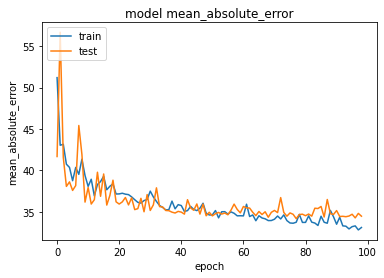

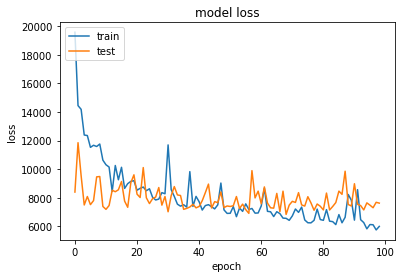

In [86]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

78/78 [==============================] - 0s 3ms/step


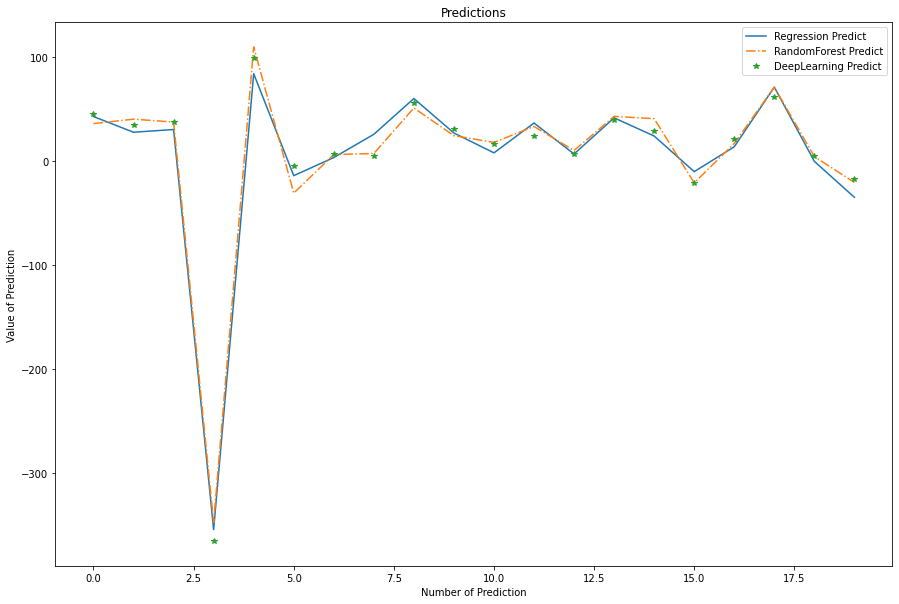

In [88]:
forestAnswer = modelForest.predict(x_test)
regAnswer = modelReg.predict(poly_transformer.transform(x_test))
deepAnswer = modelDeep.predict(x_test.values) 
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

x = list(range(0, len(x_test)))
plt.plot(x[:20], list(regAnswer)[:20], label ='Regression Predict')
plt.plot(x[:20], list(forestAnswer)[:20], '-.', label ='RandomForest Predict')
plt.plot(x[:20], list(deepAnswer)[:20], '*', label ='DeepLearning Predict')

plt.xlabel("Number of Prediction")
plt.ylabel("Value of Prediction")
plt.legend()
plt.title('Predictions')
plt.show()


In [89]:
from numpy.linalg import norm
cosine = np.dot(forestAnswer,deepAnswer)/(norm(forestAnswer)*norm(deepAnswer))
print('Cosine Similarity Between Forest and Deep',cosine[0])
cosine = np.dot(forestAnswer,regAnswer)/(norm(forestAnswer)*norm(regAnswer))
print('Cosine Similarity Between Forest and Reg',cosine)
cosine = np.dot(pd.DataFrame(deepAnswer.tolist())[0].tolist(),regAnswer)/(norm(pd.DataFrame(deepAnswer.tolist())[0].tolist())*norm(regAnswer))
print('Cosine Similarity Between Deep and Reg',cosine)


Cosine Similarity Between Forest and Deep 0.9194767633265071
Cosine Similarity Between Forest and Reg 0.8924561235033888
Cosine Similarity Between Deep and Reg 0.9835827923030349


In [104]:
print('r2_score for test set in forrstModel:',r2_score(forestAnswer,y_test))
print('r2_score for test set in deepModel:',r2_score(deepAnswer,y_test))
print('r2_score for test set in regModel:',r2_score(regAnswer,y_test))

r2_score for test set in forrstModel: 0.3181128410392947
r2_score for test set in deepModel: 0.8323839217448559
r2_score for test set in regModel: 0.8538892456769652


In [112]:
pd.DataFrame(regAnswer).rename(columns= {0:'Profit Prediction'}).to_csv('Model Prediction.csv')
pd.DataFrame(y_test).rename(columns = {'Profit':'Actual Profit'}).reset_index(drop=True).to_csv('Actual Profit.csv')